In [8]:
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
from PIL import Image
import torch.nn.functional as F
import random
from torch.utils.data import DataLoader
import csv
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_graph(name, object, label_one, std_dev=None, ylabel_loss=True, yl = None):
    plt.style.use("ggplot")
    plt.figure(figsize=(10, 5))
    plt.title(name)
    plt.plot(object, label=label_one)
    if std_dev is not None:
        plt.fill_between(range(len(object)), [m - d for m, d in zip(object, std_dev)], [m + d for m, d in zip(object, std_dev)], alpha=0.2)

    plt.xlabel("Epochs")
    if ylabel_loss:
        plt.ylabel("Loss")
    else:
        plt.ylabel("Accuracy")
    if yl is not None:
        plt.ylim(0, yl)
    plt.legend()
    plt.show()

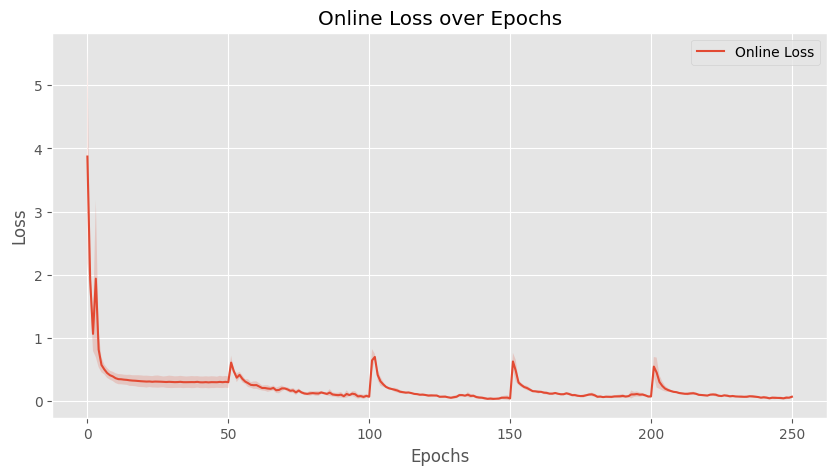

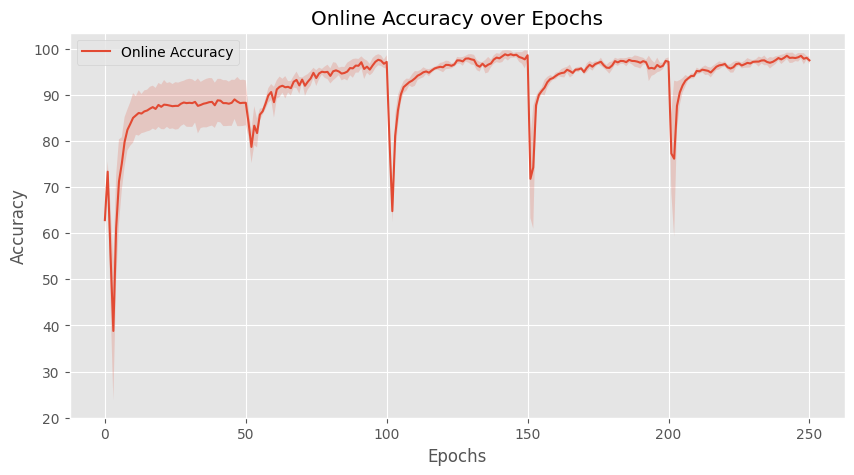

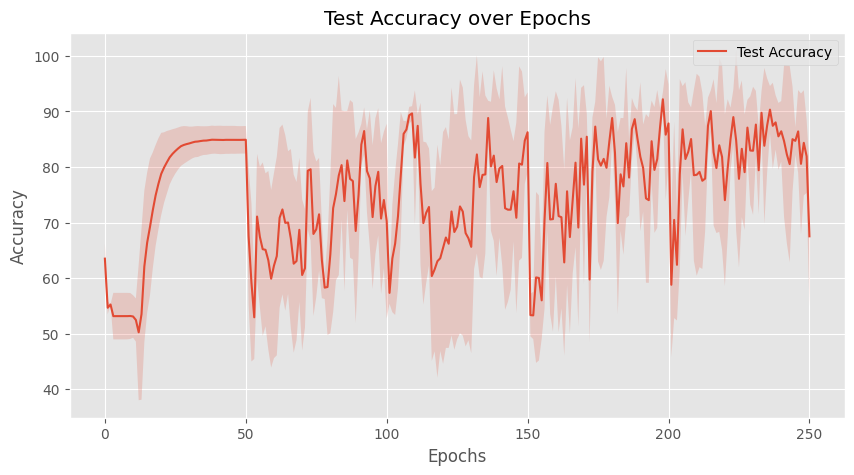

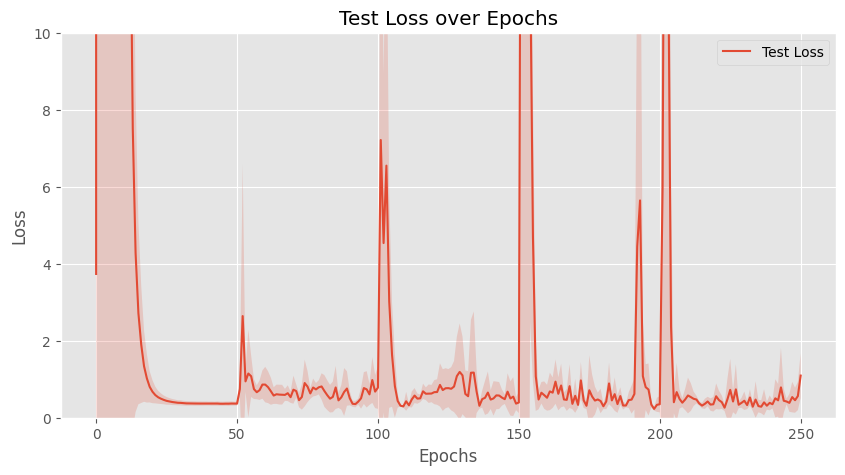

In [54]:
df_path = os.path.join('result_online','cnn_50_0.001_Adam')
df = pd.read_csv(os.path.join(df_path,'average_loss_and_accuracy'))
std = pd.read_csv(os.path.join(df_path,'std_loss_and_accuracy'))
plot_graph(name ="Online Loss over Epochs", object=df['Train Loss'], label_one='Online Loss', std_dev= std['Train Loss'])
plot_graph(name ="Online Accuracy over Epochs", object=df['Train Accuracy'], label_one='Online Accuracy', std_dev= std['Train Accuracy'], ylabel_loss = False)
plot_graph(name ="Test Accuracy over Epochs", object=df['Val Accuracy'], label_one='Test Accuracy', std_dev= std['Val Accuracy'], ylabel_loss = False)
plot_graph(name ="Test Loss over Epochs", object=df['Val Loss'], label_one='Test Loss', std_dev= std['Val Loss'], yl = 10)

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_graph_2(name, object1, label_one, object2, label_two, std_dev1=None, std_dev2=None, ylabel_loss=True, yl = None):
    plt.style.use("ggplot")
    plt.figure(figsize=(10, 5))
    #plt.title(name)
    
    plt.plot(object1, label=label_one)
    if std_dev1 is not None:
        plt.fill_between(range(len(object1)), [m - d for m, d in zip(object1, std_dev1)], [m + d for m, d in zip(object1, std_dev1)], alpha=0.2)
    
    plt.plot(object2, label=label_two)
    if std_dev2 is not None:
        plt.fill_between(range(len(object2)), [m - d for m, d in zip(object2, std_dev2)], [m + d for m, d in zip(object2, std_dev2)], alpha=0.2)
    
    plt.xlabel("Epochs")
    if ylabel_loss:
        plt.ylabel("Loss")
    else:
        plt.ylabel("Accuracy")
    if yl is not None:
        plt.ylim(0, yl)
    plt.legend()
    plt.show()

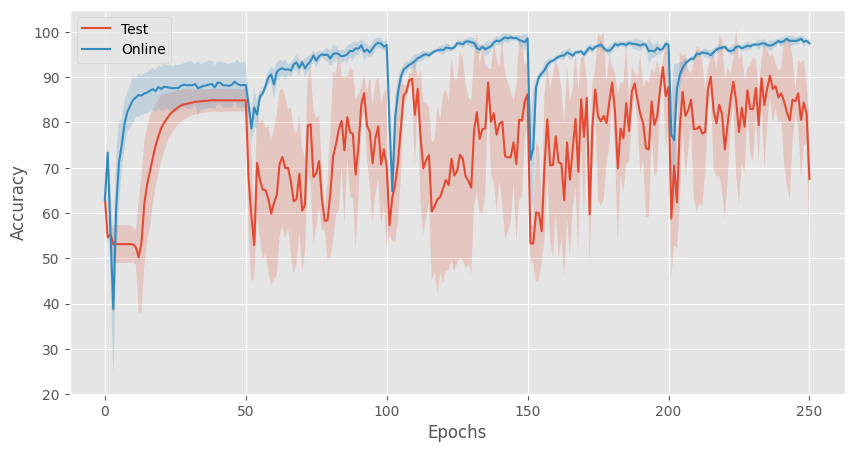

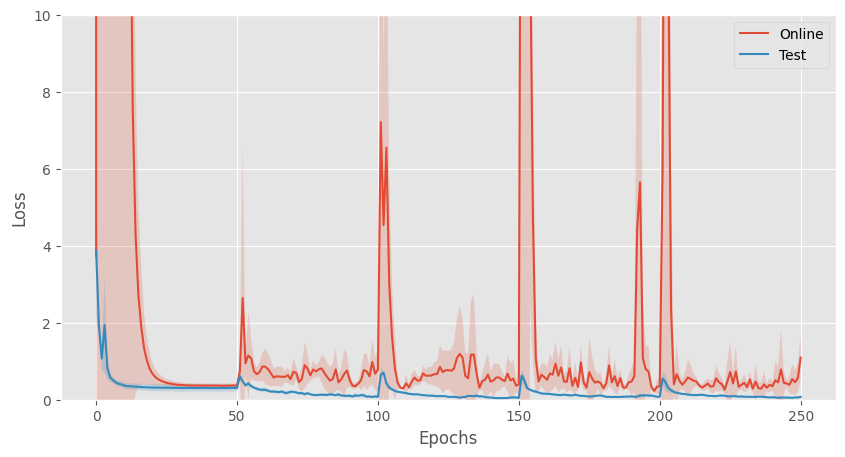

In [50]:
df_path = os.path.join('result_online','cnn_50_0.001_Adam')
df = pd.read_csv(os.path.join(df_path,'average_loss_and_accuracy'))
std = pd.read_csv(os.path.join(df_path,'std_loss_and_accuracy'))
plot_graph_2(name ="Accuracy over Epochs",
            object1=df['Val Accuracy'],
            object2=df['Train Accuracy'],
            label_one='Test',
            label_two='Online',
            std_dev1= std['Val Accuracy'],
            std_dev2= std['Train Accuracy'],
            ylabel_loss=False
            )
plot_graph_2(name ="Loss over Epochs",
            object1=df['Val Loss'],
            object2=df['Train Loss'],
            label_one='Online',
            label_two='Test',
            std_dev1= std['Val Loss'],
            std_dev2= std['Train Loss'],
            ylabel_loss=True,
            yl = 10
            )

In [19]:
n_epoch = 50
device = torch.device("cuda")
rd_accuracy = []
correct_predictions = 0
total_samples = 0

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = F.one_hot(torch.tensor(label), num_classes=2).squeeze().to(torch.float32)
        return image, label
    
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img
    
batch_size = 1024
with open("validation/image_list.txt", 'r') as f:
    lines = f.readlines()#[next(f) for _ in range(1000)] 

# Créer des listes pour stocker les chemins d'image et les étiquettes
image_paths = []
labels = []

# Parcourir chaque ligne du fichier texte et extraire les informations
for line in lines:
    line = line.strip().split(' ')
    if line[1] == "0"  or line[1] == "1":
        
        image_paths.append("validation/" + line[0])
    
        labels.append(int(line[1]))

# Appliquer les transformations d'image si nécessaire
transform_val = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: torch.flatten(x))
])
df_val = CustomDataset(image_paths, labels, transform=transform_val)
valloader = DataLoader(df_val, batch_size=batch_size, shuffle=True)


for epoch in range(n_epoch):
    rd_epoch_accuracy = 0
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in valloader:
            labels = labels.to(device)
            labels_ = torch.argmax(labels, dim=1)
            predicted = torch.randint(low=0, high=2, size=(labels_.shape[0],))
            predicted = predicted.to(device)
            correct_predictions += (predicted == labels_).sum().item()
            total_samples += labels_.shape[0]
    rd_epoch_accuracy = (correct_predictions / total_samples) * 100
    rd_accuracy.append(rd_epoch_accuracy)

    print(f"Epoch [{epoch+1}/{n_epoch}], Random Accuracy: {rd_epoch_accuracy}%")

Epoch [1/50], Random Accuracy: 49.669990169919956%
Epoch [2/50], Random Accuracy: 49.10827131020924%
Epoch [3/50], Random Accuracy: 49.922763656789776%
Epoch [4/50], Random Accuracy: 49.79637691335487%
Epoch [5/50], Random Accuracy: 50.77938491784862%
Epoch [6/50], Random Accuracy: 50.414267659036646%
Epoch [7/50], Random Accuracy: 49.89467771380424%
Epoch [8/50], Random Accuracy: 50.105322286195765%
Epoch [9/50], Random Accuracy: 49.69807611290549%
Epoch [10/50], Random Accuracy: 50.54065440247156%
Epoch [11/50], Random Accuracy: 49.05209942423817%
Epoch [12/50], Random Accuracy: 50.1755371436596%
Epoch [13/50], Random Accuracy: 49.69807611290549%
Epoch [14/50], Random Accuracy: 50.1755371436596%
Epoch [15/50], Random Accuracy: 49.684033141412726%
Epoch [16/50], Random Accuracy: 49.83850582783317%
Epoch [17/50], Random Accuracy: 49.96489257126808%
Epoch [18/50], Random Accuracy: 49.93680662828254%
Epoch [19/50], Random Accuracy: 50.091279314702994%
Epoch [20/50], Random Accuracy: 49.9

In [24]:
def plot_graph_3(name, object1, label_one, object2, label_two, object3, label_three, std_dev3 = None, std_dev1=None, std_dev2=None, ylabel_loss=True):
    plt.style.use("ggplot")
    plt.figure(figsize=(10, 5))
    #plt.title(name)
    """
    plt.plot(object1, label=label_one)
    if std_dev1 is not None:
        plt.fill_between(range(len(object1)), [m - d for m, d in zip(object1, std_dev1)], [m + d for m, d in zip(object1, std_dev1)], alpha=0.2)
    """
    plt.plot(object2, label=label_two, linestyle='dashed')
    if std_dev2 is not None:
        plt.fill_between(range(len(object2)), [m - d for m, d in zip(object2, std_dev2)], [m + d for m, d in zip(object2, std_dev2)], alpha=0.2)
    
    plt.plot(object3, label=label_three)
    if std_dev3 is not None:
        plt.fill_between(range(len(object3)), [m - d for m, d in zip(object3, std_dev3)], [m + d for m, d in zip(object3, std_dev3)], alpha=0.2)
    
    plt.xlabel("Epochs")
    if ylabel_loss:
        plt.ylabel("Loss")
    else:
        plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

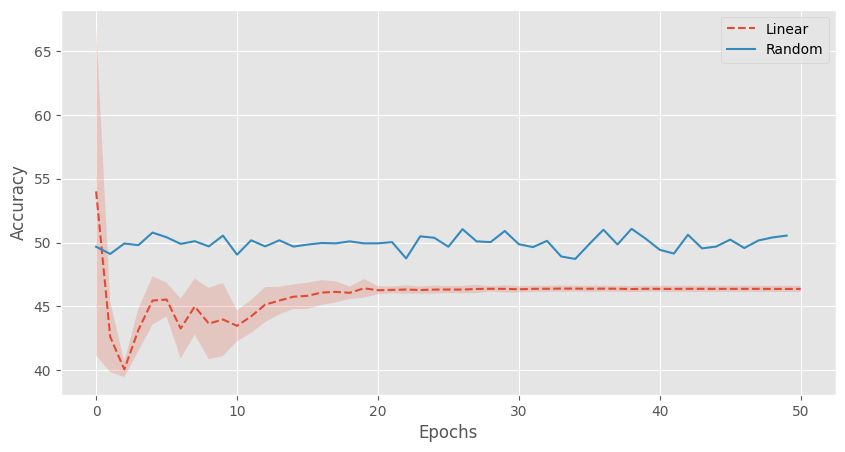

In [25]:
df_path = os.path.join('result','cnn_50_0.001_Adam')
df = pd.read_csv(os.path.join(df_path,'average_loss_and_accuracy'))
std = pd.read_csv(os.path.join(df_path,'std_loss_and_accuracy'))

df_path = os.path.join('result','linear_50_0.001_Adam')
df_linear = pd.read_csv(os.path.join(df_path,'average_loss_and_accuracy'))
std_linear = pd.read_csv(os.path.join(df_path,'std_loss_and_accuracy'))


plot_graph_3(name = 'osef',
            object1 = df['Val Accuracy'] , 
            label_one = 'ResNet18', 
            object2 = df_linear['Val Accuracy'], 
            label_two = 'Linear', 
            object3 = rd_accuracy, 
            label_three = 'Random',
            std_dev1=std['Val Accuracy'], 
            std_dev2=std_linear['Val Accuracy'], 
            ylabel_loss=False)

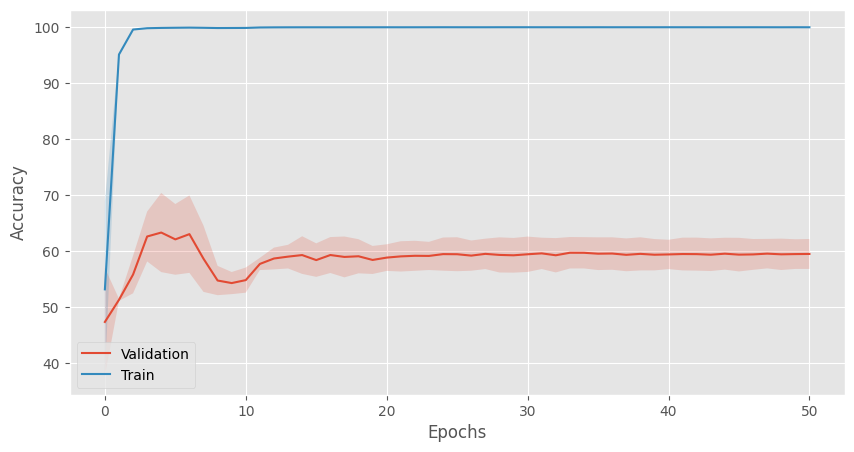

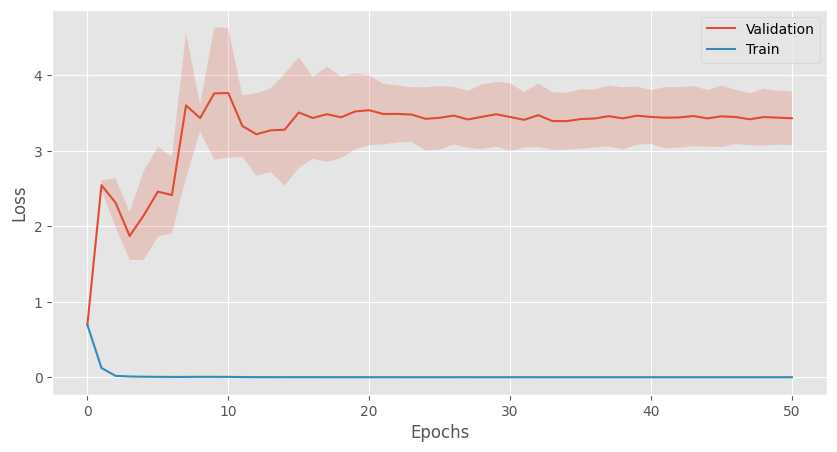

'plot_graph(name ="Loss over Epochs",\n            object1=df_linear[\'Val Accuracy\'],\n            object2=rd_accuracy,\n            label_one=\'Linear\',\n            label_two=\'Random\',\n            std_dev1= std_linear[\'Val Accuracy\'],\n            ylabel_loss=False\n            )'

In [7]:
plot_graph_2(name ="Accuracy over Epochs",
            object1=df['Val Accuracy'],
            object2=df['Train Accuracy'],
            label_one='Validation',
            label_two='Train',
            std_dev1= std['Val Accuracy'],
            std_dev2= std['Train Accuracy'],
            ylabel_loss=False
            )
plot_graph_2(name ="Loss over Epochs",
            object1=df['Val Loss'],
            object2=df['Train Loss'],
            label_one='Validation',
            label_two='Train',
            std_dev1= std['Val Loss'],
            std_dev2= std['Train Loss'],
            ylabel_loss=True
            )